In Diffusion Models, there are three important steps:

1. Adding noise to the images
2. Sampling from the model (starting from noise and getting to an image)
3. Training the model

There are three important statistical variables used in diffusion models (for making the images noisy, and sampling from the diffusion model):
1. $\beta_t \in (0, 1)$; in increasing order with respect to time (in the template code we have set $\beta_1 = 0.0001$ and $\beta_T = 0.02$)
2. $\alpha_t = 1 - \beta_t$
3. $\bar{\alpha}_t = \prod_{s=1}^t \alpha_t$

The noisy image obtained in the timestep $t$ from the original image $X_0$ can be computed as

1. sample from the Gaussian noise $\epsilon \sim \mathcal{N}(0, I)$
2. $X_t \sim \mathcal{N}(X_t; \sqrt{\bar{\alpha}_t}X_0, \sqrt{1 - \bar{\alpha}_t} \epsilon)$

Sampling from the model can be done by the follwing algorithm:

1. sample $X_T$ from the Gaussian noise $\mathcal{N}(0, I)$
2. for $t=T,..., 1$ do:
3. &nbsp;&nbsp;&nbsp;&nbsp;sample a Gaussian noise $\epsilon_t \sim \mathcal{N}(0, I)$
4. &nbsp;&nbsp;&nbsp;&nbsp;$X_{t-1}=\frac{1}{\sqrt{\alpha_t}}(X_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}}\epsilon_\theta(X_t, t)) + \sigma_t \epsilon_t$
5. endfor
6. return $X_0$

In the algorithm above, $\sigma_t = \sqrt{\beta_t}$ or $\sigma_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t}\beta_t$, and all the coefficients (including $\sigma_t$) are preferably computed inside the variance scheduler and accessed as needed. Also, $\epsilon_\theta(X_t, t)$ denotes the noise estimated by the neural network. This neural network is a UNet whose layers admit the time-embeddings as well. In class-conditional diffusion models, the labels are also embedded and combined with the time embedding.

Theoretically, training the model can be done by minimizing the Mean Squared Error between the ground truth noise and the estimated noise as in

$\|\epsilon - \epsilon_\theta(X_t, t)\|^2$

More precisely, training is done based on the following algorithm:

1. for epoch $=1,...,N$ do
2. &nbsp;&nbsp;&nbsp;&nbsp; sample $X_0$ from the data
3. &nbsp;&nbsp;&nbsp;&nbsp; uniformly sample a timestep 1,...,T
4. &nbsp;&nbsp;&nbsp;&nbsp; sample a noise $\epsilon \sim \mathcal{N}(0, I)$
5. &nbsp;&nbsp;&nbsp;&nbsp; take a gradient descent step on the loss function $\|\epsilon - \epsilon_\theta(X_t, t)\|^2$
6. endfor


In [1]:
from google.colab import drive
import os

# Google Colab Patch
use_colab = True
if use_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    # ----------------------------------------
    dir = "/content/drive/MyDrive/Cmput_328/assignment5"    # TODO: MODIFY THIS TO INDICATE THE PARENT FOLDER OF YOUR vit_model.py file
    # ----------------------------------------
    sys.path.append(dir)

Mounted at /content/drive


In [2]:
# importing the necessary packages
import torch

import matplotlib.pyplot as plt
import numpy as np

from torch import nn
from torch import optim
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from torchvision.datasets.mnist import FashionMNIST

# import your diffusion model
from A5_diffusion_submission import VarianceScheduler
from A5_diffusion_submission import NoiseEstimatingNet
from A5_diffusion_submission import DiffusionModel

In [3]:
# loading dataset
kwargs = {'root':'datasets/FashionMNIST',
          'train':True,
          'transform':transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: 2 * x - 1.)]),
          'download':True}

train_dataset = FashionMNIST(**kwargs)

train_dataset, val_dataset = random_split(train_dataset, [len(train_dataset) - 12000, 12000])

48000 12000
(28, 28, 1)


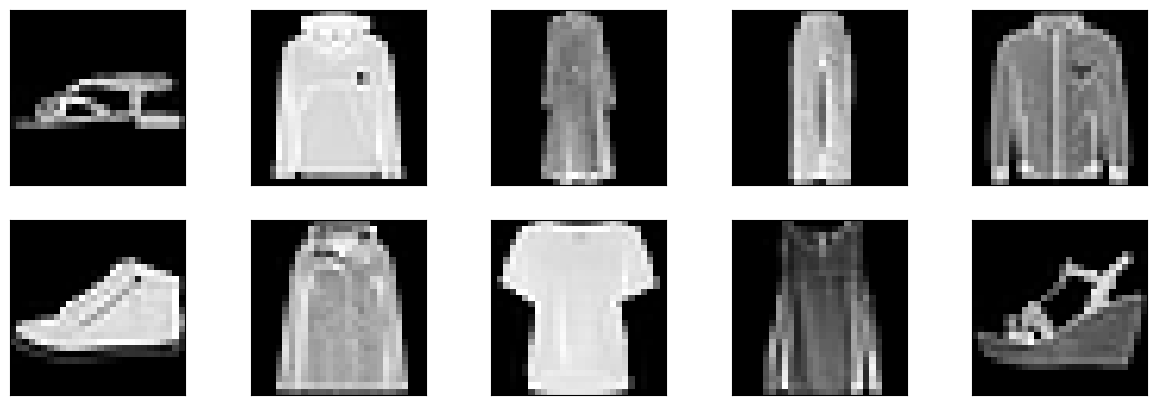

In [4]:
# showing the dataset
print(len(train_dataset), len(val_dataset))

sample_images = [train_dataset[i][0].permute(1, 2, 0).numpy() for i in range(10)]
print(sample_images[0].shape)
fig, ax = plt.subplots(2, 5)
fig.set_size_inches(15, 5)
for i in range(2):
    for j in range(5):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].imshow(sample_images[i * 5 + j], cmap='gray')
plt.show()

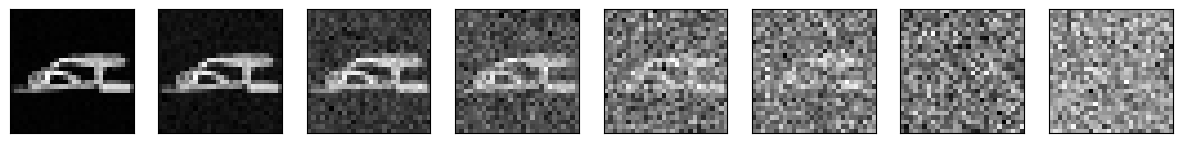

In [5]:
# testing the variance scheduler

var_schd = VarianceScheduler(num_steps=1000)

sample_image = train_dataset[0][0].unsqueeze(0)

noise_levels = [0, 10, 50, 100, 200, 300, 600, 999]

fig, ax = plt.subplots(1, 8)
fig.set_size_inches(15, 10)
for i in range(8):
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  ax[i].imshow(var_schd.add_noise(sample_image, torch.tensor(noise_levels[i]))[0].squeeze(0).permute(1, 2, 0).numpy(), cmap='gray')
plt.show()

In [6]:
def train(diffusion_model: DiffusionModel,
          train_loader: DataLoader,
          val_loader: DataLoader,
          optimizer: optim,
          epochs: int,
          device=torch.device('cuda'),
          display_interval: int=5):


  itrs = tqdm(range(epochs))
  itrs.set_description('Train Loss: ? - Val Loss: ?')

  best_loss = float('inf')
  for epoch in itrs:
    avg_train_loss = 0.
    for sample in train_loader:
      x = sample[0].to(device)
      label = sample[1].type(torch.long).to(device)

      optimizer.zero_grad()

      loss = diffusion_model(x, label)

      loss.backward()
      optimizer.step()

      avg_train_loss += loss.item()

    avg_train_loss /= len(train_loader)

    # validating and saving the model
    with torch.no_grad():
      avg_val_loss = 0.
      for sample in val_loader:
        x = sample[0].to(device)
        label = sample[1].type(torch.long).to(device)

        loss = diffusion_model(x, label)

        avg_val_loss += loss.item()

      avg_val_loss /= len(val_loader)

    itrs.set_description(f'Train Loss: {avg_train_loss:.3f} - Val Loss: {avg_val_loss:.3f}')

    # save the model on the best validation loss
    if best_loss > avg_val_loss:
      best_loss = avg_val_loss
      torch.save(diffusion_model.state_dict(), 'diffusion.pt')

    if display_interval is not None:
      if epoch % display_interval == 0 or epoch == epochs - 1:
        # generate some sample to see the quality of the generative model
        samples = diffusion_model.generate_sample(10, torch.arange(10).cuda(), torch.device('cuda'))
        fig, ax = plt.subplots(1, 10)
        fig.set_size_inches(15, 10)
        for i in range(10):
          ax[i].set_xticks([])
          ax[i].set_yticks([])
          ax[i].imshow(samples[i].cpu().permute(1, 2, 0).numpy(), cmap='gray')
        plt.show()

Train Loss: 0.136 - Val Loss: 0.071:   0%|          | 0/20 [00:35<?, ?it/s]

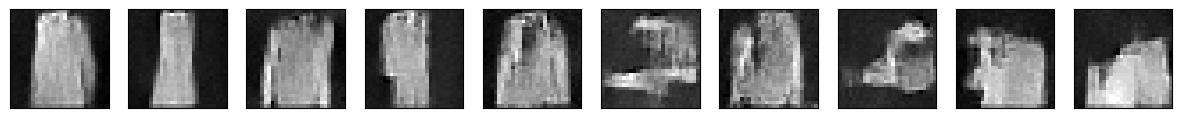

Train Loss: 0.053 - Val Loss: 0.054:  25%|██▌       | 5/20 [03:38<08:56, 35.74s/it]

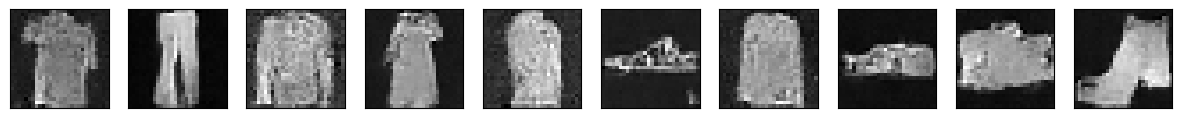

Train Loss: 0.050 - Val Loss: 0.049:  50%|█████     | 10/20 [06:35<05:46, 34.67s/it]

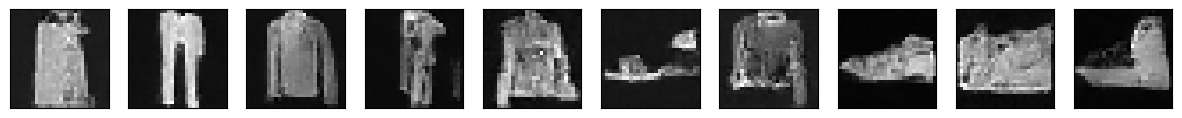

Train Loss: 0.048 - Val Loss: 0.047:  75%|███████▌  | 15/20 [09:31<02:52, 34.45s/it]

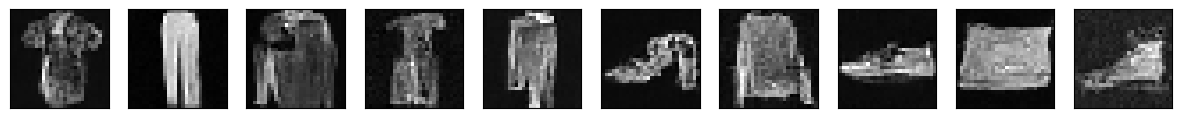

Train Loss: 0.047 - Val Loss: 0.047:  95%|█████████▌| 19/20 [11:54<00:34, 34.98s/it]

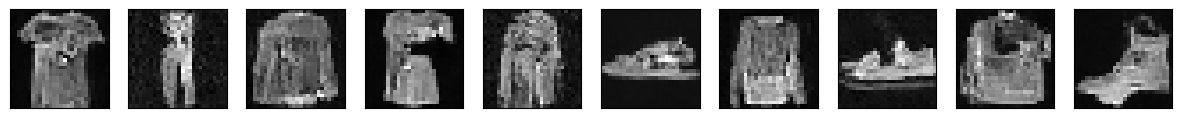

Train Loss: 0.047 - Val Loss: 0.047: 100%|██████████| 20/20 [12:04<00:00, 36.24s/it]


In [7]:
# training the diffusion model

# setting the configurations
device = torch.device('cuda')
num_steps = 1000 # define the number of steps (>500)
batch_size = 50 # define your batch size
lr = 1e-3 # specify yout
epochs = 15 # feel free to change the epochs as needed
weight_decay = 1e-4
num_classes = 10
display_interval = 5 # feel free to change; set to None if you do not want to see generated images during the training

# defining the diffusion model component nets
var_scheduler = VarianceScheduler() # define your variance scheduler
noise_net = NoiseEstimatingNet(64, 64) #define your noise estimating network

# loading a train and validation data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# defining the diffusion model
diffusion = DiffusionModel(noise_net, var_scheduler).to(device)
optimizer = optim.Adam(diffusion.parameters(), lr=lr) # specify your optimizer; e.g. optim.Adam(diffusion.parameters(), lr)

# training the diffusion model
train(diffusion_model=diffusion,
      train_loader=train_loader,
      val_loader=val_loader,
      optimizer=optimizer,
      epochs=epochs,
      device=device,
      display_interval=display_interval)


In [8]:
# a classifier trained on FashionMNIST (DO NOT CHANGE THE CODE BELOW)
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(in_features=64*7*7, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out

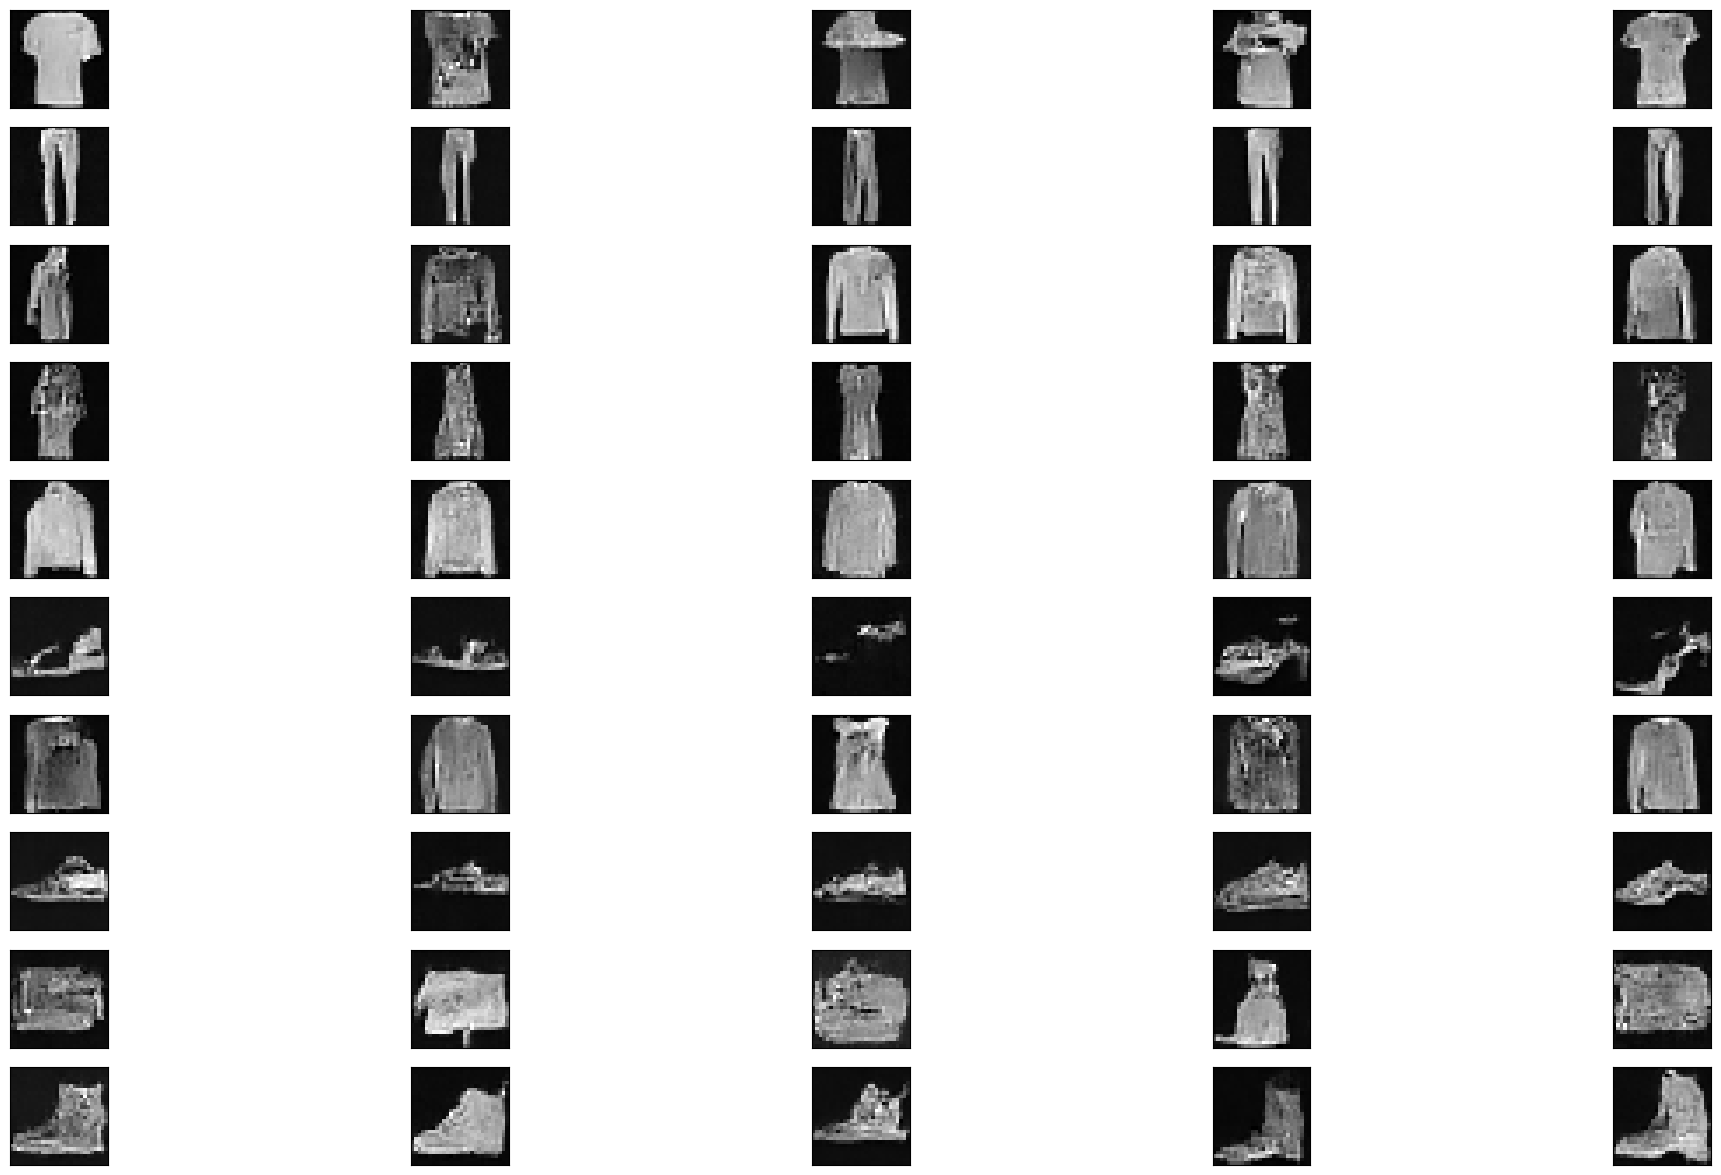

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 3, 6, 2, 2, 4, 3, 3, 3, 0, 3, 4, 4, 6, 2,
        6, 5, 5, 5, 5, 5, 2, 2, 0, 6, 4, 7, 7, 7, 7, 7, 8, 8, 8, 3, 8, 9, 9, 9,
        9, 9], device='cuda:0')
76.00


In [12]:
# here we use the classifier to see if how well it can classify the generated images (do not change the following code)
# generate 5 samples from each class
desired_labels = []
for i in range(10):
    for _ in range(5):
        desired_labels.append(i)

desired_labels = torch.tensor(desired_labels).to(device)

# load your diffusion model

diffusion.load_state_dict(torch.load('diffusion.pt'))
diffusion = diffusion.to(device)

# generate samples from the Diffusion
generated_samples = diffusion.generate_sample(50, desired_labels, device)

# normalizing the results
min_per_batch = generated_samples.flatten(start_dim=1).min(dim=-1).values.reshape(-1, 1, 1, 1)
max_per_batch = generated_samples.flatten(start_dim=1).max(dim=-1).values.reshape(-1, 1, 1, 1)

generated_samples = (generated_samples - min_per_batch) / (max_per_batch - min_per_batch)

fig, ax = plt.subplots(10, 5)
fig.set_size_inches(25, 15)
for i in range(10):
    for j in range(5):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].imshow(generated_samples[i * 5 + j].permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.show()

classifier = Classifier().to(device)
classifier.load_state_dict(torch.load('classifier.pt'))

with torch.no_grad():
    preds = classifier(generated_samples)

preds = torch.argmax(preds, dim=-1)
acc = (preds == desired_labels).sum() / 50.

print(preds)
print(f'{acc.cpu().item() * 100:.2f}')